In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import os
from os.path import expanduser
import re

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set();

from sklearn.preprocessing import *

In [3]:
home = expanduser("~")
path2data = home + '/.kaggle/competitions/recruit-restaurant-visitor-forecasting/'

## Download Dataset

In [4]:
if  not os.path.exists(path2data):
    !pip install kaggle
    !kaggle competitions download -c recruit-restaurant-visitor-forecasting -p ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting
    !cd ~/.kaggle/competitions/recruit-restaurant-visitor-forecasting && ls && unzip "*.zip"
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [5]:
files = glob.glob(path2data + '*.csv')
files

['/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/date_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/sample_submission.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_store_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_reserve.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/hpg_store_info.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/air_visit_data.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/store_id_relation.csv',
 '/home/renatolr/.kaggle/competitions/recruit-restaurant-visitor-forecasting/hpg_reserve.csv']

## Data Loading

In [6]:
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob( path2data +'*.csv')}
for k, v in dfs.items(): locals()[k] = v

- **air_store_info** contains information about select air restaurants.

- **air_visit_data** contains historical visit data for the air restaurants. It has basicaly the id of the reservation using the air system, visit_date and the number of visitors. In order to combine the provided informations with the new feature we have created a new structure **visitors**. 

- **hpg_store_info** contains information about select hpg restaurants.

- **hpg_reserve** contains informations abourt reservation made using hpg. 

- **air_reserve** contains informations abourt reservation made using air. 

In [7]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [8]:
for k,v in  dfs.items(): print(k)

date_info
sample_submission
air_store_info
air_reserve
hpg_store_info
air_visit_data
store_id_relation
hpg_reserve


**store_id_relation** has the relationship between the two separate sites in which the data comes:
    
Hot Pepper Gourmet (**hpg**): similar to Yelp, here users can search restaurants and also make a reservation online

AirREGI / Restaurant Board (**air**): similar to Square, a reservation control and cash register system

In [9]:
store_id_relation.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [10]:
air_info = air_reserve.merge(air_store_info, on='air_store_id', how='left', suffixes=('', '_y'))

In [11]:
data = air_visit_data.merge(air_store_info, on='air_store_id', how='left', suffixes=('', '_y'))
data = data.merge(store_id_relation, on='air_store_id', how='left', suffixes=('', '_y')) 
data = data.merge(hpg_store_info, on='hpg_store_id', how='left', suffixes=('', '_y'))

In [12]:
data.head(2)

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


**Date info** carry out information about the calendary. Has proposed by [zeemeen](https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st) we have created a new feature **Weight** which creates a podenration factor around the days that are holidays.

In [13]:
wkend_holidays = date_info.apply(lambda x: (x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1, axis=1)
wkend_holidays.value_counts()

date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5

In [14]:
date_info.head(5)

,calendar_date,day_of_week,holiday_flg,weight
0,2016-01-01,Friday,1,2.707368e-14
1,2016-01-02,Saturday,0,8.663577e-13
2,2016-01-03,Sunday,0,6.578904e-12
3,2016-01-04,Monday,0,2.772345e-11
4,2016-01-05,Tuesday,0,8.460525e-11


In [15]:
data = data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
data.drop('calendar_date', axis=1, inplace=True)

data['visitors_log'] = data.visitors.map(pd.np.log1p)

Text(0.5,1,'Log Visitors distribution')

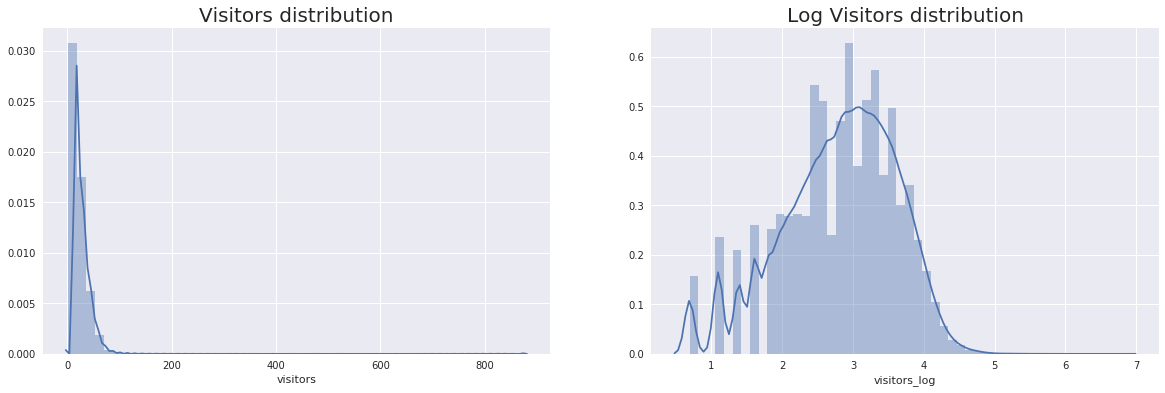

In [16]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.distplot(data['visitors'])
plt.title('Visitors distribution', fontsize=20)

plt.subplot(1,2,2)
sns.distplot(data['visitors_log'])
plt.title('Log Visitors distribution', fontsize=20)

In [17]:
data.head(2)

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,day_of_week,holiday_flg,weight,visitors_log
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,Wednesday,0,1.005227e-08,3.258097
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,Thursday,0,1.456087e-08,3.496508


In [18]:
data[['visitors', 'visitors_log']].describe()

,visitors,visitors_log
count,252108.000000,252108.000000
mean,20.973761,2.802788
std,16.757007,0.807726
min,1.000000,0.693147
25%,9.000000,2.302585
50%,17.000000,2.890372
75%,29.000000,3.401197
max,877.000000,6.777647


### Weather informations

In order to create a more robust model, we have used information about the [weather](https://www.kaggle.com/huntermcgushion/rrv-weather-data). The cell bellow will download automatically this dataset. To add the precipitation and avg_temperature it will be used the function [add_weather](https://gist.github.com/superMDguy/72689a11746079677ddb0d19f26443a1) as demonstrated bellow.

In [19]:
path2weather = 'raw/weather/'

In [20]:
if  not os.path.exists(path2weather):
    !wget -O rrv-weather-data.zip "https://storage.googleapis.com/kaggle-datasets/7480/12096/rrv-weather-data.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528816610&Signature=kDnX2dX3Pd8VGbR6rqRmDH7XYFjBiKYnz3hoez3AWjv0oUf2vJKLpYKV7zfLb%2FgNJE2kXy9D8%2BNvmNkx4LrJHRvVrIMsGyMe%2FM0x1Z3Kxk6nJMSI9BDZGhsyBSONBKPNdND%2FEHuo2k1T2Wo8tOBu1VOOQlLt8NkblTCBx3ihEvEapCq6UgtfNvYvnE55MI8TBCNLcMBBBUU3Cv251yywybyUTAGRfWfIoc2hcYkrVV0j8EtOCfX5CKrAmvxhnuzLBKvlapIrYmOLRtwjlyFfQh2nWqpQGb7ORj%2BUfTvL3trMgOd06aozbCj4A207p%2FBd2IBEweYElxsgddGdpwaLHg%3D%3D"
    !mkdir -p raw/weather/
    !mv rrv-weather-data.zip raw/weather/
    !cd raw/weather/ && unzip rrv-weather-data.zip
else:
    print('Weather Dataset already downloaded!')

Weather Dataset already downloaded!


In [21]:
# This is an example of the used weather file
pd.read_csv(path2weather + '1-1-16_5-31-17_Weather/tokyo__tokyo-kana__tonokyo.csv').head()

,calendar_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,solar_radiation,deepest_snowfall,total_snowfall,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover
0,2016-01-01,7.5,12.1,3.6,NaN,9.0,11.80,NaN,NaN,2.6,4.5,1022.4,45.0,1025.4,2.5
1,2016-01-02,7.3,13.4,2.6,NaN,7.5,11.59,NaN,NaN,1.9,5.2,1018.6,51.0,1021.5,4.3
2,2016-01-03,9.3,16.2,3.0,NaN,8.3,10.77,NaN,NaN,1.4,7.0,1013.2,61.0,1016.2,5.3
3,2016-01-04,9.2,15.2,4.4,NaN,8.9,11.19,NaN,NaN,1.6,6.8,1010.4,60.0,1013.3,0.0
4,2016-01-05,10.9,15.4,5.1,NaN,8.4,10.57,NaN,NaN,1.8,6.5,1013.1,51.0,1016.0,2.8


In [22]:
def add_weather(dataset, path2weather='raw/weather/'):                                                                                                                     
    print('Adding weather...')                                                                                                                
    air_nearest = pd.read_csv(                                                                                                                
        path2weather + 'air_store_info_with_nearest_active_station.csv')                                                              
    unique_air_store_ids = list(dataset.air_store_id.unique())                                                                                
                                                                                                                                              
    weather_dir = path2weather + '1-1-16_5-31-17_Weather/'                                                                            
    weather_keep_columns = ['precipitation', 'avg_temperature']                                                                                                                         
                                                                                                                                              
    dataset_with_weather = dataset.copy()                                                                                                     
    for column in weather_keep_columns:                                                                                                       
        dataset_with_weather[column] = np.nan
        
    for air_id in unique_air_store_ids:                                                                                                       
        station = air_nearest[air_nearest.air_store_id == air_id].station_id.iloc[0]  
        weather_data = pd.read_csv(weather_dir + station + '.csv', parse_dates=['calendar_date']).rename(columns={'calendar_date': 'visit_date'})                                                                                                                                               
        
        #change datetime format
        weather_data['visit_date'] = weather_data['visit_date'].dt.strftime('%Y-%m-%d')
        this_store = dataset.air_store_id == air_id                                                                                           
        merged = dataset[this_store].merge(weather_data, on='visit_date', how='left')                                                         
        for column in weather_keep_columns:                                                                                                   
            dataset_with_weather.loc[this_store, column] = merged[column]           
    

        
    return dataset_with_weather    

In [23]:
air_store_info_with_active_station = pd.read_csv(path2weather + 'air_store_info_with_nearest_active_station.csv')

In [24]:
data = pd.merge(left=data, right=air_store_info_with_active_station, on='air_store_id', how='left', suffixes=('', '_y'))

In [25]:
data = add_weather(data)

Adding weather...


In [26]:
# Handle missing data
# We could replace this block by the avg_temperature and precipitation of stations which are closer

data['precipitation'].fillna(data.precipitation.mean(), inplace=True)
data['avg_temperature'].fillna(data.avg_temperature.mean(), inplace=True)

In [27]:
def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)
    return df

In [28]:
data = drop_y(data)

### Extract informations about the spatial location of the restaurant
    - Todofuken
    - city
    - street

In [29]:
area  = data.air_area_name.str.split(' ', expand=True)

data['nb_Todofuken'] = area[0]
data['nb_city'] = area[1]
data['nb_street'] = area.iloc[:, 2:].apply(lambda row: ' '.join(row.dropna()), axis=1)

Text(0.5,1,'Number of restaurant in each city')

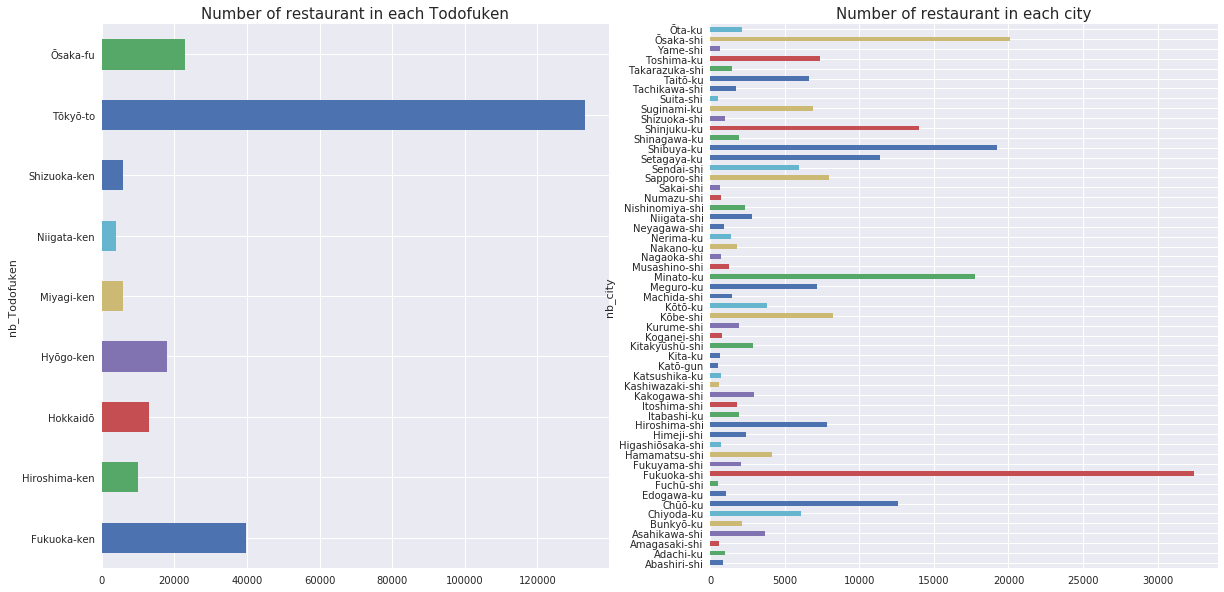

In [30]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
data.groupby(['nb_Todofuken']).size().plot(kind = 'barh')
plt.title('Number of restaurant in each Todofuken', fontsize=15)

plt.subplot(1,2,2)
data.groupby(['nb_city']).size().plot(kind = 'barh')
plt.title('Number of restaurant in each city', fontsize=15)

In [31]:
print('Dataset shape: {}'.format(data.shape))

Dataset shape: (252108, 26)


In [32]:
data.head(2)

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,...,station_id,station_latitude,station_longitude,station_vincenty,station_great_circle,precipitation,avg_temperature,nb_Todofuken,nb_city,nb_street
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,NaN,4.3,Tōkyō-to,Minato-ku,Shibakōen
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,tokyo__tokyo-kana__tonokyo,35.691667,139.75,3.730672,3.739835,NaN,6.0,Tōkyō-to,Minato-ku,Shibakōen


### Obtain informations about reservations

In [35]:
air_reserve['visit_datetime'] = air_reserve.visit_datetime.astype('datetime64[ns]')
air_reserve['reserve_ahead'] = air_reserve.visit_datetime.astype('datetime64[ns]') - air_reserve.reserve_datetime.astype('datetime64[ns]')
air_reserve['reserve_ahead_seconds'] = air_reserve['reserve_ahead'].apply(lambda x: x.seconds)

In [36]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,reserve_ahead,reserve_ahead_seconds
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,03:00:00,10800
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,00:00:00,0
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,00:00:00,0
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,04:00:00,14400
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,19:00:00,68400


In [39]:
data  =  pd.merge(left=data,  right=air_reserve, how='left', 
                left_on=['air_store_id', 'visit_date'], 
                right_on=['air_store_id', 'visit_datetime'])

In [40]:
data.shape

(252108, 31)

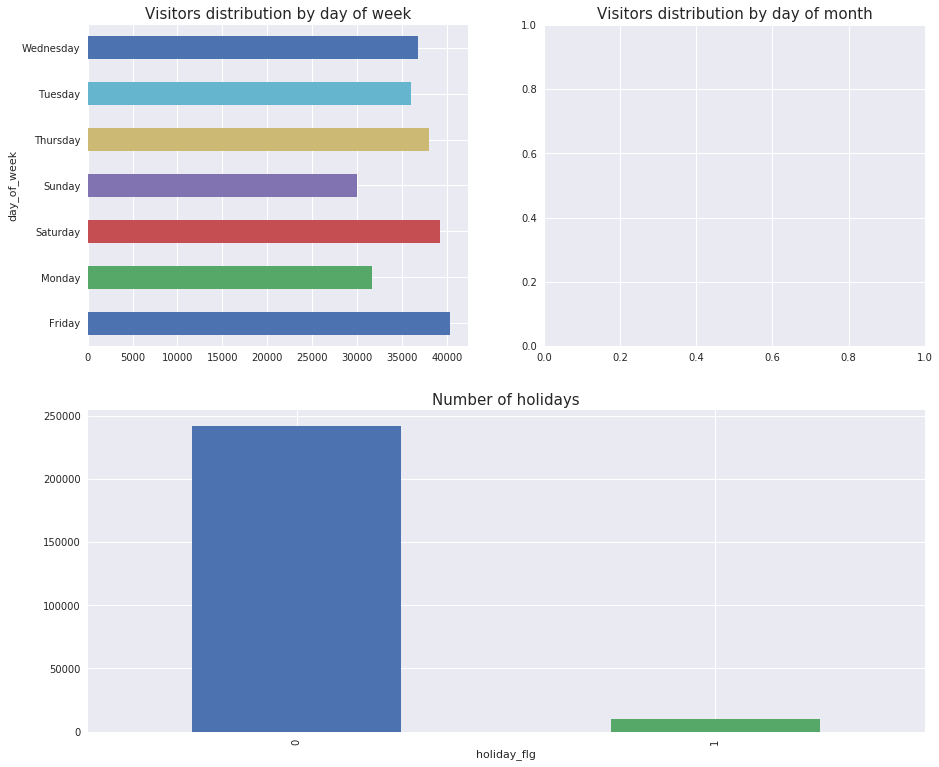

In [48]:
plt.figure(figsize=(15,13))
plt.subplot(2,2,1)
plt.title('Visitors distribution by day of week', fontsize=15)
data.groupby('day_of_week')['visitors'].count().plot(kind = 'barh')

plt.subplot(2,2,2)
plt.title('Visitors distribution by day of month', fontsize=15)

plt.subplot(2,2,(3,4))
plt.title('Number of holidays', fontsize=15)
data.groupby('holiday_flg').size().plot(kind = 'bar')

In [49]:
data.keys()

Index(['air_store_id', 'visit_date', 'visitors', 'air_genre_name',
       'air_area_name', 'latitude', 'longitude', 'hpg_store_id',
       'hpg_genre_name', 'hpg_area_name', 'day_of_week', 'holiday_flg',
       'weight', 'visitors_log', 'latitude_str', 'longitude_str', 'station_id',
       'station_latitude', 'station_longitude', 'station_vincenty',
       'station_great_circle', 'precipitation', 'avg_temperature',
       'nb_Todofuken', 'nb_city', 'nb_street', 'visit_datetime',
       'reserve_datetime', 'reserve_visitors', 'reserve_ahead',
       'reserve_ahead_seconds'],
      dtype='object')

In [50]:
data.head()

,air_store_id,visit_date,visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,...,precipitation,avg_temperature,nb_Todofuken,nb_city,nb_street,visit_datetime,reserve_datetime,reserve_visitors,reserve_ahead,reserve_ahead_seconds
0,air_ba937bf13d40fb24,2016-01-13,25,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,NaN,4.3,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaN,NaN,NaT,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,NaN,6.0,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaN,NaN,NaT,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0.0,5.6,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaN,NaN,NaT,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,NaN,6.5,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaN,NaN,NaT,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,67.0,2.8,Tōkyō-to,Minato-ku,Shibakōen,NaT,NaN,NaN,NaT,NaN


In [28]:
visitors = data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(lambda x:( (x.weight * x.visitors_log).sum() / x.weight.sum() )).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) 

In [29]:
visitors.head(5)

,air_store_id,day_of_week,holiday_flg,visitors
0,air_00a91d42b08b08d9,Friday,0,3.583535
1,air_00a91d42b08b08d9,Monday,0,3.203625
2,air_00a91d42b08b08d9,Monday,1,3.091042
3,air_00a91d42b08b08d9,Saturday,0,2.524065
4,air_00a91d42b08b08d9,Sunday,0,1.098612


Text(0.5,1,'Visitors Distribution')

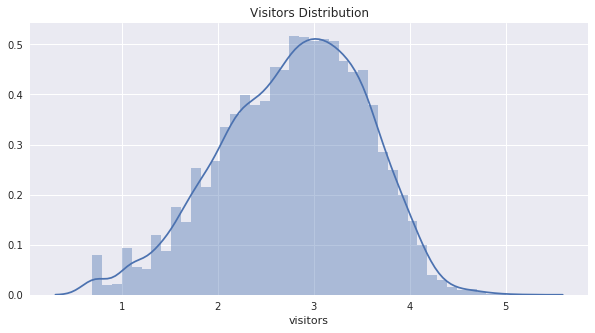

In [30]:
plt.figure(figsize=(10,5))
sns.distplot(visitors['visitors'])
#plt.xscale('log')
plt.title("Visitors Distribution")